In [1]:
import sys
sys.path.append('../scripts/')
from ideal_robot import *
from scipy.stats import expon, norm,uniform # 指数分布の機能を提供するオブジェクト

In [2]:
class Robot(IdealRobot):
    # noise_per_meter:1mあたりの小石の数 noise_std:小石を踏んだときにロボットの向きに発生する雑音の標準偏差
    # expected_stuck_time:スタックするまでの時間の期待値（平均タイム） expected_escape_time:スタックから脱出するまでの時間（平均タイム）
    # expected_kidnap_time:誘拐される時間周期
    def __init__(self, pose, agent = None, sensor = None , color = "black",\
                noise_per_meter = 5,noise_std = math.pi/60,\
                bias_rate_stds = (0.1,0.1),\
                expected_stuck_time = 1e100,expected_escape_time = 1e-100,\
                expected_kidnap_time = 1e100,kidnap_range_x = (-5.0,5.0),kidnap_range_y = (-5.0,5.0)):
        
        super().__init__(pose,agent,sensor,color) # super() IdealRobotのinitを呼び出す
        
        self.noise_pdf = expon(scale = 1.0 / (1e-100 + noise_per_meter)) # scale = 1/(λ + 10^-100) 指数分布
        self.distance_until_noise = self.noise_pdf.rvs()
        self.theta_noise = norm(scale = noise_std) # 小石踏んだときの誤差する角度
        self.bias_rate_nu = norm.rvs(loc = 1.0,scale = bias_rate_stds[0]) # 正規分布
        self.bias_rate_omega = norm.rvs(loc = 1.0,scale = bias_rate_stds[1])
        # loc:平均 scale:標準偏差 size:サンプル数
        
        self.stuck_pdf = expon(scale = expected_stuck_time) # 確立密度関数作成
        self.escape_pdf = expon(scale = expected_escape_time)
        self.time_until_stuck = self.stuck_pdf.rvs()
        self.time_until_escape = self.escape_pdf.rvs()
        self.is_stuck = False
        
        self.kidnap_pdf = expon(scale = expected_kidnap_time) # 一様分布
        self.time_until_kidnap = self.kidnap_pdf.rvs()
        rx,ry = kidnap_range_x,kidnap_range_y
        self.kidnap_dist = uniform(loc = (rx[0],ry[0],0.0),scale = (rx[1] - rx[0],ry[1] - ry[0],2 * math.pi))
        
    
    
    # 速度と角速度にバイアスをかける
    def bias(self,nu,omega):
        return nu * self.bias_rate_nu , omega * self.bias_rate_omega
    
    # ガウス分布上にセンサ値をばらつかせる
    def noise(self,pose,nu,omega,time_interval):
        # 直進と回転で進む床面の距離
        self.distance_until_noise -= abs(nu)*time_interval + self.r*abs(omega)*time_interval
        if self.distance_until_noise <= 0.0: # distance_until_noiseが0かどうか判定
            self.distance_until_noise += self.noise_pdf.rvs()
            pose[2] += self.theta_noise.rvs()
            
        return pose
    
    def stuck(self,nu,omega,time_interval):
        if self.is_stuck:
            self.time_until_escape -= time_interval
            if self.time_until_escape <= 0.0:
                self.time_until_escape += self.escape_pdf.rvs()
                self.is_stuck = False
                
        else:
            self.time_until_stuck -= time_interval
            if self.time_until_stuck <= 0.0:
                self.time_until_stuck += self.stuck_pdf.rvs()
                self.is_stuck = True
        
        return nu * (not self.is_stuck),omega * (not self.is_stuck)
    
    def kidnap(self,pose,time_interval):
        self.time_until_kidnap -= time_interval
        if self.time_until_kidnap <= 0.0:
            self.time_until_kidnap += self.kidnap_pdf.rvs()
            return np.array(self.kidnap_dist.rvs()).T
        else:
            return pose
    
    def one_step(self, time_interval):
        if not self.agent: return
        obs = self.sensor.data(self.pose) if self.sensor else None
        nu, omega = self.agent.decision(obs) # 速度と角速度を取り出す
        nu, omega = self.bias(nu,omega)      # 取り出したらバイアス
        nu, omega = self.stuck(nu,omega,time_interval)
        self.pose = self.state_transition(nu,omega,time_interval,self.pose)
        self.pose = self.noise(self.pose, nu, omega, time_interval)
        self.pose = self.kidnap(self.pose,time_interval)


In [3]:
class Camera(IdealCamera):
    def __init__(self,env_map,
                 distance_range = (0.5,6.0),
                 direction_range = (-math.pi/3,math.pi/3),
                 distance_noise_rate = 0.1,direction_noise = math.pi / 90,
                 distance_bias_rate_stddev = 0.1,direction_bias_stddev = math.pi / 90): # ←距離と角度に関するノイズの標準偏差
        
        super().__init__(env_map,distance_range,direction_range)
        
        self.distance_noise_rate = distance_noise_rate
        self.direction_noise = direction_noise
        
        self.distance_bias_rate_std = norm.rvs(scale = distance_bias_rate_stddev)
        self.direction_bias = norm.rvs(scale = direction_bias_stddev)
        
    def bias(self,relpos):
        return relpos + np.array([relpos[0] * self.distance_bias_rate_std,
                                  self.direction_bias]).T
        
    # relpos:曲座標で表現されているセンサ値
    # センサ値をガウス分布でバラす
    
    def noise(self,relpos):
        ell = norm.rvs(loc = relpos[0],scale = relpos[0] * self.distance_noise_rate)
        phi = norm.rvs(loc = relpos[1],scale = self.direction_noise)
        return np.array([ell,phi]).T
    
        
    def data(self,cam_pose):
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose,lm.pos) # 関数h
            if self.visible(z):
                z = self.bias(z)
                z = self.noise(z)
                observed.append((z,lm.id))
        
        self.lastdata = observed
        return observed
                
        self.lastdata = observed
        return observed

<IPython.core.display.Javascript object>


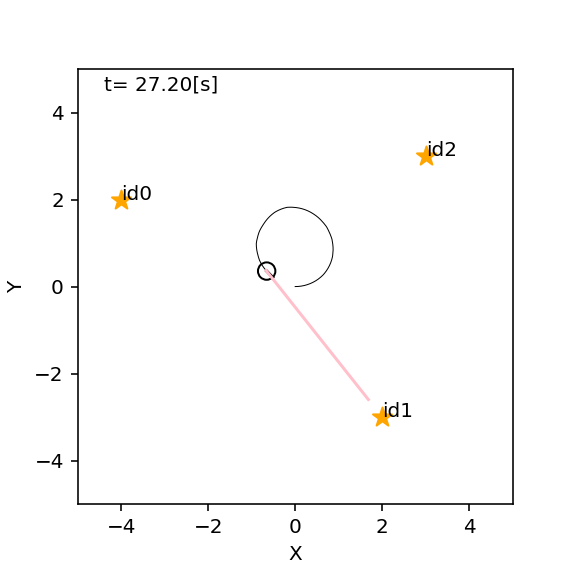

In [4]:
import copy

world = World(30,0.1)
m = Map()
m.append_landmark(Landmark(-4,2))
m.append_landmark(Landmark(2,-3))
m.append_landmark(Landmark(3,3))

world.append(m)

circling = Agent(0.2,10.0 / 180 * math.pi)
r = Robot(np.array([0,0,0]).T, sensor = Camera(m), agent = circling)
world.append(r)

world.draw()
# センサがぶれるようにした
# バイアス追加